# Good-bye Pandas! Meet Terality - Its Evil Twin With Identical Syntax
## ... but up to 30 times faster
![](images/unsplash.jpg)

## Setup

In [1]:
import logging
import time
import warnings

import catboost as cb
import datatable as dt
import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
import umap
import umap.plot
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.compose import *
from sklearn.impute import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import *

logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S", level=logging.INFO
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
pd.set_option("float_format", "{:.5f}".format)

In [20]:
def plot_comparison(te_scre, pd_score, title):
    fig, ax = plt.subplots(figsize=(10, 4))

    bars = ax.barh(
        ["Terality", "Pandas"], [te_scre, pd_score], color="black", height=0.4
    )
    ax.bar_label(bars, fontsize=12, fmt="%gs")

    [plt.setp(ax.spines[spine], visible=False) for spine in ax.spines]
    ax.tick_params(
        axis="both",
        which="both",
        left=False,
        bottom=False,
        labelbottom=False,
        labelsize=12,
    )

    ax.set_title(title, size=15, color="#E50914")

    plt.show()

    return fig

# Introduction

As in everything, we are spoilt for choice when working with big data. The number one tool being Pandas, then the likes of Dask, Vaex, Datatable, cuDF, you name it. As if these weren't enough, we now add **Terality** to the list.

Is Terality one of those packages that tries to replace the turtle speed of Pandas at the cost of its so beloved simplicity and flexibility? 

No, Terality is Pandas' evil twin born with superpowers. It has identical syntax with Pandas but works at lightening speed and doesn't depend on your machine to work its magic. 

Sounds too good to be true? Read on. 

## What is Terality and how does it work?

Terality is a serverless data processing engine running on giant clusters. You can work with datasets of any humongous size blazing fast without worrying about scaling resources on the clusters or any infrastructure. 

This means two things:

1. There is virtually no limit on memory, thus on the dataset size.
2. You only need a good Internet connection to process hundreds of GBs even on a 4GB RAM machine.

And the selling point of Terality - its Python package has the exact same syntax as Pandas. You only need to change a single line of code to switch from Pandas to Terality.

![](images/5.png)

The Python package sends HTTPS requests to the Terality engine when you call Pandas functions. The engine processes the data and the command and sends back the result. 

The setup also takes about a minute. You install the library with `pip` and enter your API to hook up your machine to the engine. It is all here in this [link](https://app.terality.com/).

# Preparing a dataset

```python
import pandas as pd

df = pd.read_csv("data/train.csv")

large_df = df.sample(6 * 10 ** 7, replace=True)  # 60 million rows

large_df.to_parquet(
    "data/tps_may_large.parquet", row_group_size=len(df) // 15, engine="pyarrow"
)
```

In [2]:
from pathlib import Path

size = Path("data/tps_may_large.parquet").stat().st_size
size_in_gb = size / 1024 ** 3

round(size_in_gb, 2)  # size in gb

7.1

## Pandas vs. Terality - loading data

In [3]:
import pandas as pd

In [4]:
%%time

df = pd.read_parquet("data/tps_may_large.parquet")
df.head()

Wall time: 1min 13s


,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
182422,304374,B,I,C,A,E,BI,A,E,AE,...,0.31483,0.33758,0.58846,0.81205,0.39941,0.34741,0.36246,0.47965,0.38859,0
293498,489146,A,I,F,A,H,BI,A,AD,AT,...,0.78550,0.26256,0.79709,0.61876,0.68503,0.51610,0.69893,0.64765,0.39339,0
220335,367472,B,I,A,C,F,AB,A,AH,AY,...,0.47273,0.27432,0.23982,0.73472,0.47775,0.45875,0.33995,0.56523,0.41739,0
215241,358783,A,I,A,A,H,BI,A,AN,AD,...,0.86646,0.74539,0.66882,0.61945,0.54771,0.82895,0.81539,0.36399,0.63882,0
265936,443252,A,J,C,A,E,T,A,A,AX,...,0.30859,0.30910,0.80339,0.29991,0.55434,0.33210,0.24322,0.25736,0.31435,0


In [5]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000000 entries, 182422 to 262725
Data columns (total 32 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      int64  
 1   cat0    object 
 2   cat1    object 
 3   cat2    object 
 4   cat3    object 
 5   cat4    object 
 6   cat5    object 
 7   cat6    object 
 8   cat7    object 
 9   cat8    object 
 10  cat9    object 
 11  cat10   object 
 12  cat11   object 
 13  cat12   object 
 14  cat13   object 
 15  cat14   object 
 16  cat15   object 
 17  cat16   object 
 18  cat17   object 
 19  cat18   object 
 20  cont0   float64
 21  cont1   float64
 22  cont2   float64
 23  cont3   float64
 24  cont4   float64
 25  cont5   float64
 26  cont6   float64
 27  cont7   float64
 28  cont8   float64
 29  cont9   float64
 30  cont10  float64
 31  target  int64  
dtypes: float64(11), int64(2), object(19)
memory usage: 68.0 GB


In [7]:
import terality as te

In [8]:
%%time

df_te = te.read_parquet("s3://sample-bucket-for-medium/tps_may_large.parquet")
df_te.head()

17-Jan-22 14:18:51 - Found credentials in shared credentials file: ~/.aws/credentials


Wall time: 1min 24s


,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
182422,304374,B,I,C,A,E,BI,A,E,AE,A,DP,A,A,A,A,B,D,D,B,0.282072,0.290521,0.314827,0.337578,0.588459,0.812049,0.399413,0.347415,0.362455,0.479648,0.388591,0
293498,489146,A,I,F,A,H,BI,A,AD,AT,A,HK,A,A,A,A,B,B,D,B,0.389077,0.927745,0.785501,0.262564,0.797093,0.618762,0.685029,0.516098,0.698928,0.647654,0.393393,0
220335,367472,B,I,A,C,F,AB,A,AH,AY,A,MS,A,A,A,A,D,D,D,B,0.487649,0.453483,0.472732,0.274317,0.239821,0.734716,0.477748,0.458747,0.339953,0.565235,0.417390,0
215241,358783,A,I,A,A,H,BI,A,AN,AD,E,HQ,A,A,A,B,A,D,D,B,0.642140,0.786709,0.866463,0.745388,0.668823,0.619450,0.547709,0.828951,0.815386,0.363989,0.638822,0
265936,443252,A,J,C,A,E,T,A,A,AX,A,DP,A,A,A,A,A,D,D,B,0.271567,0.194787,0.308595,0.309102,0.803394,0.299911,0.554340,0.332101,0.243223,0.257364,0.314352,0


In [9]:
df_te.info(memory_usage=True)

<class 'terality.DataFrame'>
Index: 60000000 entries, 182422 to 262725
Data columns (total 32 columns):
 #   Column  Dtype
---  ------  -----
 0   id      int64
 1   cat0    object
 2   cat1    object
 3   cat2    object
 4   cat3    object
 5   cat4    object
 6   cat5    object
 7   cat6    object
 8   cat7    object
 9   cat8    object
10   cat9    object
11   cat10   object
12   cat11   object
13   cat12   object
14   cat13   object
15   cat14   object
16   cat15   object
17   cat16   object
18   cat17   object
19   cat18   object
20   cont0   float64
21   cont1   float64
22   cont2   float64
23   cont3   float64
24   cont4   float64
25   cont5   float64
26   cont6   float64
27   cont7   float64
28   cont8   float64
29   cont9   float64
30   cont10  float64
31   target  int64
dtypes: int64(2), object(19), float64(11)
memory usage: 68.0 GB (run with deep=True)


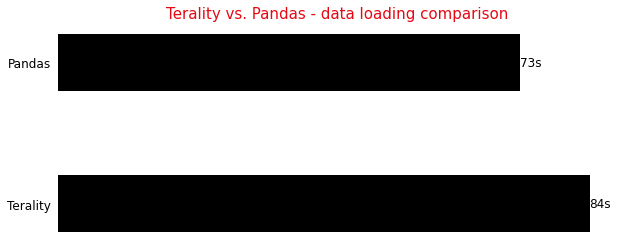

In [21]:
fig = plot_comparison(84, 73, "Terality vs. Pandas - data loading comparison")
fig.savefig("images/loading.png")

## Syntax

## Common pandas operations

#### Grouping

In [21]:
%%time

df.groupby("cat3").mean().drop("id", axis=1)

Wall time: 1min 6s


,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
cat3,,,,,,,,,,,,
A,0.47484,0.48474,0.50285,0.44800,0.49047,0.50933,0.51456,0.47300,0.48412,0.45761,0.47579,0.25743
B,0.54604,0.48820,0.51798,0.51428,0.51796,0.46695,0.42848,0.54295,0.48947,0.47298,0.55418,0.26676
C,0.53370,0.54485,0.55813,0.49551,0.51095,0.56996,0.53422,0.52099,0.48092,0.47489,0.52658,0.32051
D,0.72420,0.61351,0.67166,0.66201,0.63535,0.53091,0.35604,0.70183,0.53815,0.66459,0.74150,0.18451
E,0.48231,0.48096,0.52250,0.49316,0.54680,0.43917,0.46309,0.50240,0.47091,0.46569,0.52977,0.26580
F,0.52671,0.52325,0.56577,0.45012,0.61938,0.55312,0.47172,0.54224,0.49648,0.54098,0.54139,0.38694
G,0.52321,0.71398,0.71513,0.45587,0.51736,0.70611,0.66760,0.56612,0.66419,0.54056,0.53358,0.52131
H,0.55495,0.54888,0.58269,0.53827,0.50055,0.37866,0.40755,0.57208,0.55672,0.51980,0.59058,0.28097
I,0.37222,0.29641,0.33203,0.31914,0.41357,0.39084,0.44959,0.31630,0.34047,0.44905,0.37810,0.32351


In [22]:
%%time

df_te.groupby("cat3").mean().drop("id", axis=1)

Wall time: 26.4 s


,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
cat3,,,,,,,,,,,,
A,0.474845,0.484744,0.502852,0.447997,0.490474,0.509327,0.514556,0.473003,0.484122,0.457615,0.475791,0.257429
B,0.546037,0.488200,0.517984,0.514282,0.517961,0.466951,0.428482,0.542947,0.489472,0.472978,0.554182,0.266761
C,0.533700,0.544852,0.558128,0.495509,0.510952,0.569959,0.534220,0.520994,0.480920,0.474894,0.526582,0.320509
D,0.724202,0.613509,0.671663,0.662010,0.635353,0.530907,0.356037,0.701827,0.538151,0.664595,0.741498,0.184513
E,0.482308,0.480960,0.522504,0.493158,0.546799,0.439167,0.463089,0.502396,0.470911,0.465691,0.529768,0.265799
...,...,...,...,...,...,...,...,...,...,...,...,...
I,0.372218,0.296410,0.332032,0.319145,0.413573,0.390844,0.449588,0.316295,0.340470,0.449048,0.378105,0.323514
J,0.398603,0.497155,0.524971,0.276669,0.631157,0.605152,0.650176,0.417293,0.526405,0.325700,0.394716,0.313291
K,0.505899,0.802544,0.817042,0.302025,0.492921,0.697053,0.780635,0.487120,0.807649,0.501662,0.497817,0.812513


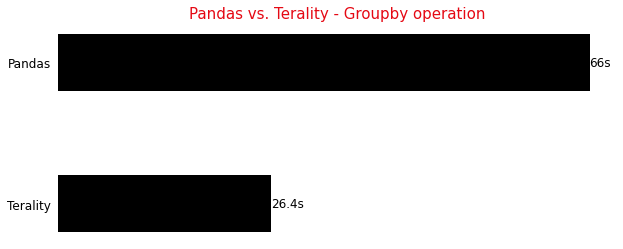

In [22]:
fig = plot_comparison(26.4, 66, "Pandas vs. Terality - Groupby operation")
fig.savefig("images/groupby.png")

#### Sorting

In [24]:
%%time

result = df.sort_values(by="cont5", ascending=False)
result.head()

Wall time: 3min 20s


,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
179851,300051,B,F,A,B,G,BI,C,AS,A,...,0.43100,0.26179,0.71291,0.85302,0.76067,0.41565,0.60751,0.26465,0.42208,0
179851,300051,B,F,A,B,G,BI,C,AS,A,...,0.43100,0.26179,0.71291,0.85302,0.76067,0.41565,0.60751,0.26465,0.42208,0
179851,300051,B,F,A,B,G,BI,C,AS,A,...,0.43100,0.26179,0.71291,0.85302,0.76067,0.41565,0.60751,0.26465,0.42208,0
179851,300051,B,F,A,B,G,BI,C,AS,A,...,0.43100,0.26179,0.71291,0.85302,0.76067,0.41565,0.60751,0.26465,0.42208,0
179851,300051,B,F,A,B,G,BI,C,AS,A,...,0.43100,0.26179,0.71291,0.85302,0.76067,0.41565,0.60751,0.26465,0.42208,0


In [25]:
%%time

result = df_te.sort_values(by="cont5", ascending=False)
result.head()

Wall time: 58.3 s


,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
179851,300051,B,F,A,B,G,BI,C,AS,A,A,GS,A,A,A,A,C,C,D,C,0.340314,0.707281,0.431003,0.261791,0.712914,0.853022,0.76067,0.415646,0.607509,0.264648,0.422077,0
179851,300051,B,F,A,B,G,BI,C,AS,A,A,GS,A,A,A,A,C,C,D,C,0.340314,0.707281,0.431003,0.261791,0.712914,0.853022,0.76067,0.415646,0.607509,0.264648,0.422077,0
179851,300051,B,F,A,B,G,BI,C,AS,A,A,GS,A,A,A,A,C,C,D,C,0.340314,0.707281,0.431003,0.261791,0.712914,0.853022,0.76067,0.415646,0.607509,0.264648,0.422077,0
179851,300051,B,F,A,B,G,BI,C,AS,A,A,GS,A,A,A,A,C,C,D,C,0.340314,0.707281,0.431003,0.261791,0.712914,0.853022,0.76067,0.415646,0.607509,0.264648,0.422077,0
179851,300051,B,F,A,B,G,BI,C,AS,A,A,GS,A,A,A,A,C,C,D,C,0.340314,0.707281,0.431003,0.261791,0.712914,0.853022,0.76067,0.415646,0.607509,0.264648,0.422077,0


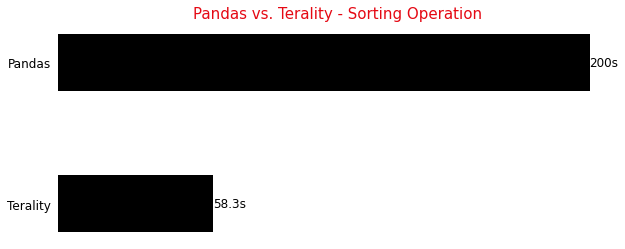

In [23]:
fig = plot_comparison(58.3, 200, "Pandas vs. Terality - Sorting Operation")

fig.savefig("images/sorting.png")

#### Creating a new column

In [34]:
%%time

df["new"] = df["cont0"].apply(lambda x: np.sqrt(np.exp(x)))
df["new"].sample(5)

Wall time: 2min 25s


145053   1.40283
286303   1.27540
103920   1.16384
85100    1.29126
216857   1.17710
Name: new, dtype: float64

In [35]:
%%time

df_te["new"] = df_te["cont0"].apply(lambda x: np.sqrt(np.exp(x)))
df_te["new"].sample(5)

Wall time: 1min 11s


64783     1.263485
260467    1.046370
245600    1.321468
269796    1.312624
192964    1.072801
Name: new, dtype: float64

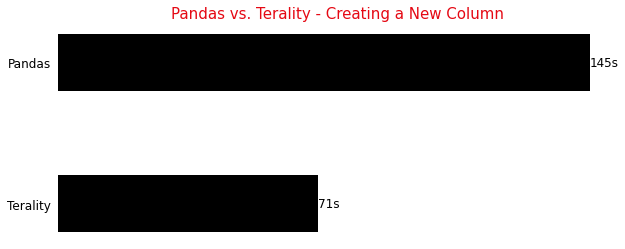

In [24]:
fig = plot_comparison(71, 145, "Pandas vs. Terality - Creating a New Column")
fig.savefig("images/new_col.png")